In [ ]:
# pour naviguer dans les répertoires
import os 
# pour manipuler les DataFrames
import pandas as pd
# pour ouvrir et inspecter les images
from PIL import Image

import numpy as np

# -----------------------------
# Parcours du dataset et collecte des métadonnées
# -----------------------------

# Répertoire de base où sont stockées les variantes d’images
base_dir = "../dataset/plantvillage/data/plantvillage_5images"
# liste qui accueillera un dict par image
data = []


# On parcourt les variantes/sous-dossiers "color", "grayscale", "segmented"
for variant in os.listdir(base_dir):
    variant_path = os.path.join(base_dir, variant)
    
    # Vérifie que c'est bien un dossier (pas un fichier)
    if os.path.isdir(variant_path):
        # Puis on parcourt chaque dossier d’espèce+disease
        for folder_name in os.listdir(variant_path):
            folder_path = os.path.join(variant_path, folder_name)
            
            if os.path.isdir(folder_path):
                # Extraire l’espèce et la maladie depuis le nom de dossier
                # Exemple : "Apple_scab__Powdery_mildew"
                if '__' in folder_name:
                    species, disease = folder_name.split('__', 1)
                else:
                    species, disease = folder_name, 'unknown'

                # Parcours de toutes les images dans ce dossier
                for image_name in os.listdir(folder_path):
                    image_path = os.path.join(folder_path, image_name)
                    
                    try:
                        # Ouverture sécurisée de l’image
                        with Image.open(image_path) as img:
                            # dimensions en pixels
                            width, height = img.size
                            # mode de couleur, ex RGB, grayscale,..
                            mode = img.mode  

                            # 2) Convertit en tableau NumPy et calcule mean/std par canal
                            arr = np.array(img)  # shape = (H, W, 3)
                            mean_R, mean_G, mean_B = arr.mean(axis=(0,1)).tolist()
                            std_R,  std_G,  std_B  = arr.std(axis=(0,1)).tolist()

                    except Exception as e:
                        # En cas d’erreur (fichier corrompu…), on l’affiche et on passe
                        print(f"Erreur avec {image_path} : {e}")
                        continue

                    # On stocke toutes les infos extraites dans un dict
                    data.append({
                        'image_path': image_path.replace('\\', '/'),
                        'variant': variant,  # color, grayscale ou segmented
                        'species': species,  # nom de l’espèce
                        'disease': disease, # type de maladie (ou 'unknown')
                        'width': width, # largeur
                        'height': height, # hauteur
                        'mode': mode,  # ex. 'RGB' 
                         # colonnes couleur globale
                        'mean_R': mean_R, 'mean_G': mean_G, 'mean_B': mean_B,
                        'std_R':  std_R,  'std_G':  std_G,  'std_B':  std_B
                    })

# Création du DataFrame pandas à partir de la liste de dicts
df = pd.DataFrame(data)
# Affichage des premières lignes pour vérifier la structure
print(df.head())
# Liste des colonnes disponibles dans le DF
print("\nColonnes disponibles :", df.columns.tolist())
# Statistiques descriptives sur les dimensions
print("\nDimensions des images :")
print(df[['width', 'height']].describe())

# Compte des différents modes d’image (RGB, L pour grayscale, etc.)
print("\nTypes d’image :", df['mode'].value_counts())
# Répartition du nombre d’images par variante (color, grayscale, segmented)
print("\nRépartition des variantes :", df['variant'].value_counts())

# Distribution des espèces
print(df['species'].value_counts())
# Distribution des maladies
print(df['disease'].value_counts())


                                          image_path variant species  \
0  ../dataset/plantvillage/data/plantvillage_5ima...   color   Apple   
1  ../dataset/plantvillage/data/plantvillage_5ima...   color   Apple   
2  ../dataset/plantvillage/data/plantvillage_5ima...   color   Apple   
3  ../dataset/plantvillage/data/plantvillage_5ima...   color   Apple   
4  ../dataset/plantvillage/data/plantvillage_5ima...   color   Apple   

       disease  width  height mode      mean_R      mean_G      mean_B  \
0  _Apple_scab    256     256  RGB  110.662399  130.183029  119.862732   
1  _Apple_scab    256     256  RGB   84.160263   97.555771  103.142639   
2  _Apple_scab    256     256  RGB   92.535965  125.726334  116.025253   
3  _Apple_scab    256     256  RGB  129.896759  125.648727  114.409760   
4  _Apple_scab    256     256  RGB   86.708450  101.711456  101.433350   

       std_R      std_G      std_B  
0  44.746098  35.313362  57.454225  
1  30.019544  23.166413  47.930225  
2  34.04157

In [61]:
# -----------------------------
# Nettoyage (images corrompues ou sans dimensions)
# -----------------------------
#df[df.isna().any(axis=1)]

print(df.shape)


# nettoyage : on enlève les lignes contenant des NaN sur les colonnes clés
df_clean = df.dropna(subset=['image_path', 'width', 'height', 'mode'])
# On enlève aussi les images de taille nulle
df_clean = df_clean[(df_clean['width'] > 0) & (df_clean['height'] > 0)]

print(df.shape)

# Vérification des images mal chargées ou sans dimensions
bad = df[(df['width'].isna()) | (df['height'].isna()) |
         (df['width'] == 0) | (df['height'] == 0)]
print("Exemples d’images mal chargées :", bad)

# Pour gérér les erreurs à l’ouverture
try:
    with Image.open(image_path) as img:
        width, height = img.size
        mode = img.mode
except Exception as e:
    print(f"Problème avec : {image_path} -> {e}")


# -----------------------------
# Création de la clé de stratification
# -----------------------------

# création colonne combinée qui sera utilisée dans stratify pour garantir que chaque couple espèce + maladie est 
# réparti proportionnellement entre train et test.> stratify attend une série (une seule colonne), pas un DataFrame
df_clean['stratify_key'] = df_clean['species'] + '__' + df_clean['disease']

# vérification qu’aucune classe combinée n’est trop rare, qu’aucune classe n’est trop petite pour le split
print("Nombre minimum d’exemples par (espèce,maladie) : ",df_clean['stratify_key'].value_counts().min(), )



(570, 13)
(570, 13)
Exemples d’images mal chargées : Empty DataFrame
Columns: [image_path, variant, species, disease, width, height, mode, mean_R, mean_G, mean_B, std_R, std_G, std_B]
Index: []
Nombre minimum d’exemples par (espèce,maladie) :  15


In [62]:
# Visualisation rapide des stats globales
print(df[['mean_R','mean_G','mean_B']].describe().round(1))
print(df[['std_R','std_G','std_B']].describe().round(1))

       mean_R  mean_G  mean_B
count   570.0   570.0   570.0
mean     96.2   103.6    89.4
std      40.9    36.9    42.3
min      10.4    16.1    10.7
25%      55.7    73.7    44.0
50%     111.0   113.2   103.3
75%     124.3   126.8   120.1
max     191.8   200.5   189.9
       std_R  std_G  std_B
count  570.0  570.0  570.0
mean    45.6   47.7   44.7
std     11.6   15.2   10.5
min     13.4   16.3   16.3
25%     38.1   36.3   37.5
50%     45.4   46.6   44.7
75%     53.3   58.3   52.2
max     82.4   96.0   74.5


In [63]:
# -----------------------------
# Train/Test split
# -----------------------------
from sklearn.model_selection import train_test_split

# Split train/test stratifié selon cette clé
# stratify : pour garantir tirage proportionnel aux classes > like tirage au sort par categorie
X_train, X_test = train_test_split(
    df_clean,
    test_size=0.2, # 20% des données en test
    stratify=df_clean['stratify_key'], # répartition proportionnelle par clé
    random_state=42 # pour être reproductible
)

print(f"Train shape: {X_train.shape},  Test shape: {X_test.shape}")

Train shape: (456, 14),  Test shape: (114, 14)


In [64]:
# -----------------------------
# Création de df_sorted pour la suite de l’exploration
# -----------------------------
# Trie les données pour plus de lisibilité par espèce, puis maladie, puis variante, puis chemin
df_sorted = df_clean.sort_values(
    by=["species", "disease", "variant", "image_path"]
).reset_index(drop=True)

df_sorted = df_sorted.rename(columns={"image_path": "filepath"})

print("df_sorted head:")
print(df_sorted.head())

df_sorted head:
                                            filepath variant species  \
0  ../dataset/plantvillage/data/plantvillage_5ima...   color   Apple   
1  ../dataset/plantvillage/data/plantvillage_5ima...   color   Apple   
2  ../dataset/plantvillage/data/plantvillage_5ima...   color   Apple   
3  ../dataset/plantvillage/data/plantvillage_5ima...   color   Apple   
4  ../dataset/plantvillage/data/plantvillage_5ima...   color   Apple   

       disease  width  height mode      mean_R      mean_G      mean_B  \
0  _Apple_scab    256     256  RGB  110.662399  130.183029  119.862732   
1  _Apple_scab    256     256  RGB   84.160263   97.555771  103.142639   
2  _Apple_scab    256     256  RGB   92.535965  125.726334  116.025253   
3  _Apple_scab    256     256  RGB  129.896759  125.648727  114.409760   
4  _Apple_scab    256     256  RGB   86.708450  101.711456  101.433350   

       std_R      std_G      std_B        stratify_key  
0  44.746098  35.313362  57.454225  Apple___Apple

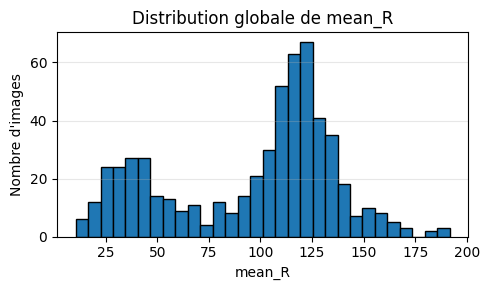

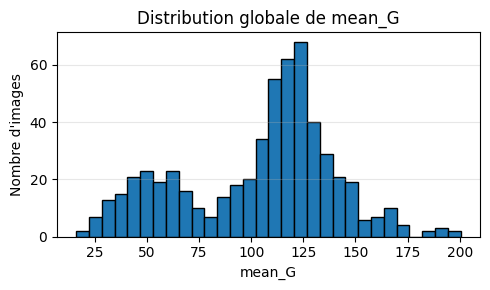

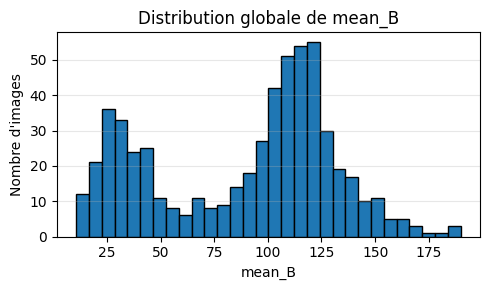

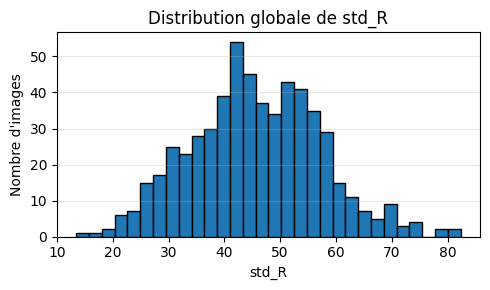

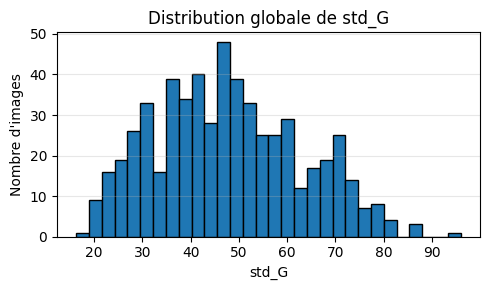

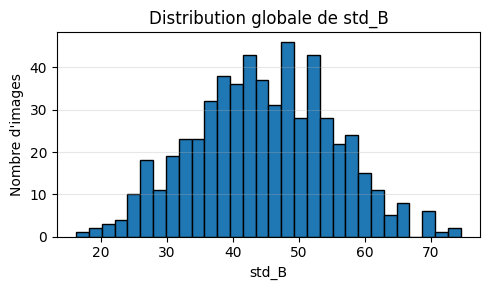

C:\Users\PERCHECMorgan\AppData\Local\Temp\ipykernel_7100\2584215986.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_cls, labels=classes, showfliers=True)


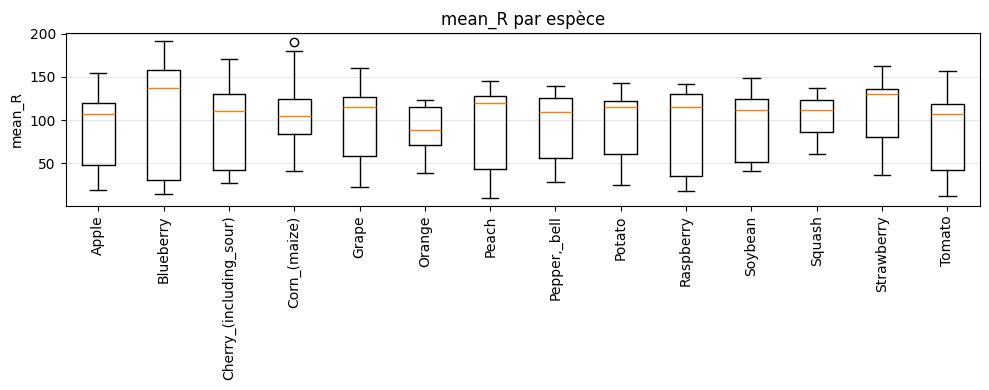

C:\Users\PERCHECMorgan\AppData\Local\Temp\ipykernel_7100\2584215986.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_cls, labels=classes, showfliers=True)


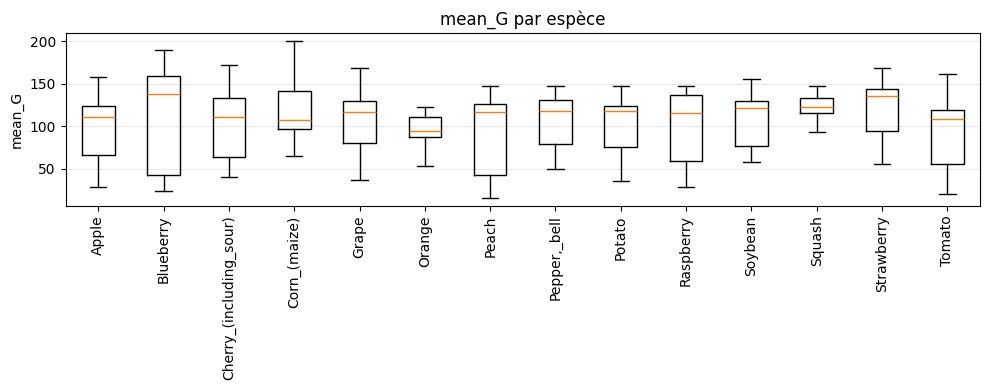

C:\Users\PERCHECMorgan\AppData\Local\Temp\ipykernel_7100\2584215986.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_cls, labels=classes, showfliers=True)


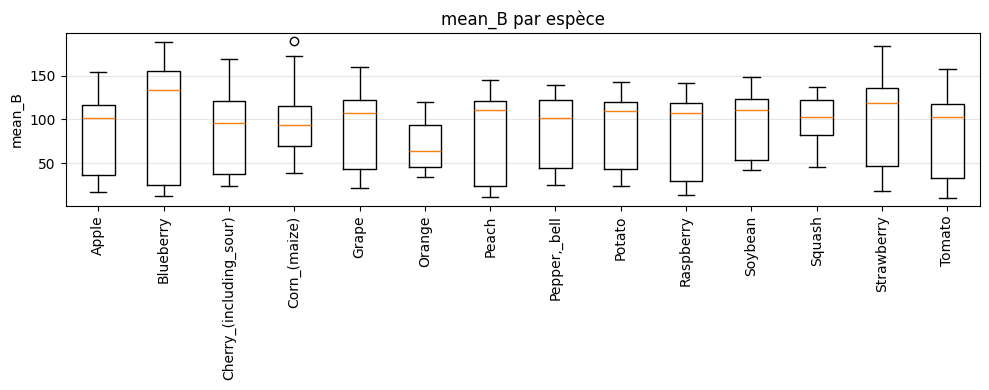

C:\Users\PERCHECMorgan\AppData\Local\Temp\ipykernel_7100\2584215986.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_cls, labels=classes, showfliers=True)


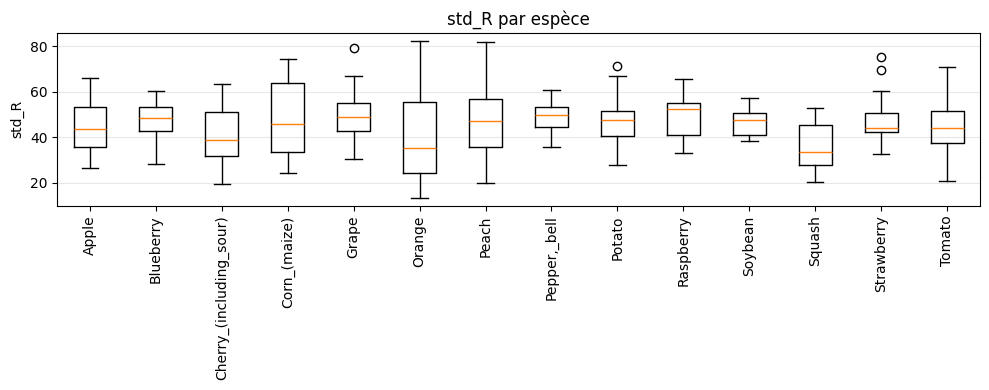

C:\Users\PERCHECMorgan\AppData\Local\Temp\ipykernel_7100\2584215986.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_cls, labels=classes, showfliers=True)


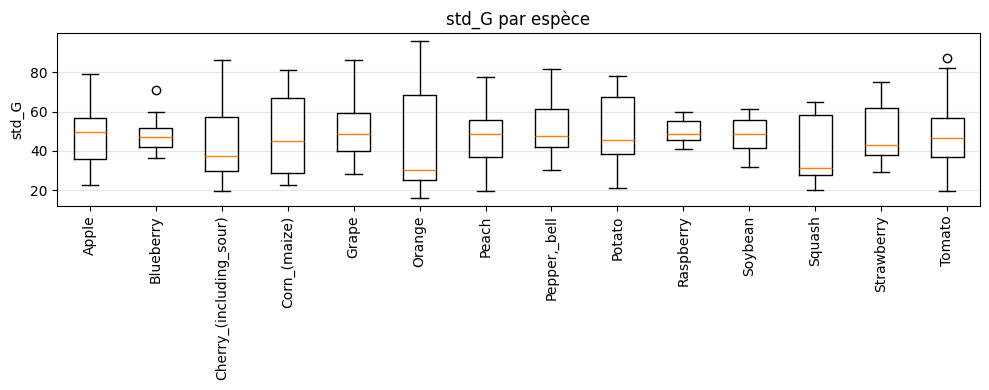

C:\Users\PERCHECMorgan\AppData\Local\Temp\ipykernel_7100\2584215986.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_cls, labels=classes, showfliers=True)


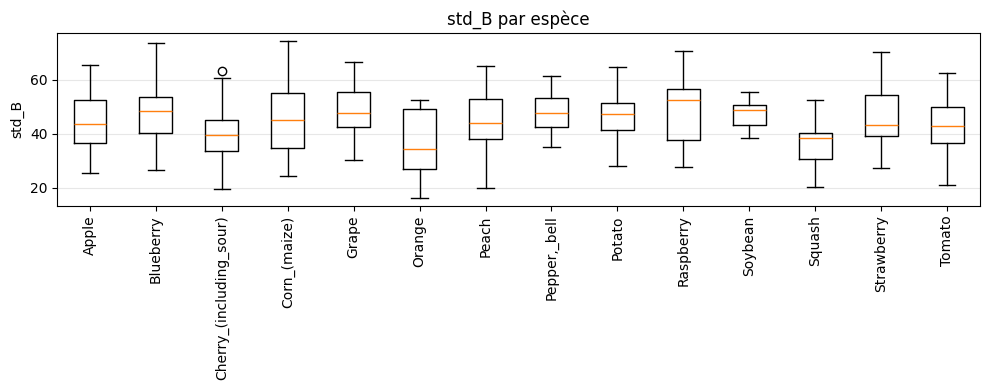

In [74]:
import matplotlib.pyplot as plt
#  moyenne et ecart type par canal
features = ['mean_R','mean_G','mean_B','std_R','std_G','std_B']

# Histogrammes globaux des moyennes et écarts-types
for col in features:
    plt.figure(figsize=(5,3))
    plt.hist(df_sorted[col], bins=30, edgecolor='k')
    plt.title(f"Distribution globale de {col}")
    plt.xlabel(col)
    plt.ylabel("Nombre d'images")
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Boxplots par espèce pour évaluer la séparation
classes = df_sorted['species'].unique()
for col in features:
    data_by_cls = [df_sorted.loc[df_sorted['species']==c, col] 
                   for c in classes]
    plt.figure(figsize=(10,4))
    plt.boxplot(data_by_cls, labels=classes, showfliers=True)
    plt.xticks(rotation=90)
    plt.title(f"{col} par espèce")
    plt.ylabel(col)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [73]:
print("refaire analyse par variant : color ")

refaire analyse par variant : color 


In [ ]:


import cv2
import numpy as np
import pandas as pd

def compute_color_summaries(df_paths: pd.DataFrame, bins: int = 32):
    """
    Bins = 32 pour ùmatcher avec choix optimal cf plus bas
    Prend en entrée un DataFrame contenant au moins la colonne 'filepath',
    et pour chaque image :
      1) calcule l'histogramme couleur brut pour chaque canal (R,G,B) avec `bins` bacs
      2) en tire les stats mean/std/skew/entropy/dark/bright
    Retourne un nouveau DataFrame enrichi de ces colonnes.
    """
    # pré-allouer les listes
    summaries = {
        'R_mean_bin':[], 'R_std_bin':[], 'R_skewness_bin':[], 'R_entropy_bin':[], 'R_dark_ratio':[], 'R_bright_ratio':[],
        'G_mean_bin':[], 'G_std_bin':[], 'G_skewness_bin':[], 'G_entropy_bin':[], 'G_dark_ratio':[], 'G_bright_ratio':[],
        'B_mean_bin':[], 'B_std_bin':[], 'B_skewness_bin':[], 'B_entropy_bin':[], 'B_dark_ratio':[], 'B_bright_ratio':[]
    }
    
    idx = np.arange(bins)
    
    for path in df_paths['filepath']:
        # charger et convertir
        img = cv2.imread(path)
        if img is None:
            # en cas de problème, on remplit par des zéros
            for k in summaries: summaries[k].append(0)
            continue
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # pour chaque canal
        for ci, ch_name in enumerate(['R','G','B']):
            ch = rgb[..., ci]
            # histogramme brut
            h = cv2.calcHist([ch], [0], None, [bins], [0, 256]).flatten().astype(float)
            s = h.sum() + 1e-6
            # stats
            mean    = (h * idx).sum() / s
            var     = (h * (idx - mean)**2).sum() / s
            std     = np.sqrt(var)
            skew    = (h * (idx - mean)**3).sum() / (s * (std**3 + 1e-6))
            entropy = -(h * np.log(h + 1e-6)).sum()
            dark    = h[0] / s
            bright  = h[-1]/ s
            
            # stockage
            summaries[f'{ch_name}_mean_bin'].append(mean)
            summaries[f'{ch_name}_std_bin'].append(std)
            summaries[f'{ch_name}_skewness_bin'].append(skew)
            summaries[f'{ch_name}_entropy_bin'].append(entropy)
            summaries[f'{ch_name}_dark_ratio'].append(dark)
            summaries[f'{ch_name}_bright_ratio'].append(bright)
    
    # Construire le DataFrame final
    df_out = df_paths.copy().reset_index(drop=True)
    for k,v in summaries.items():
        df_out[k] = v
    return df_out



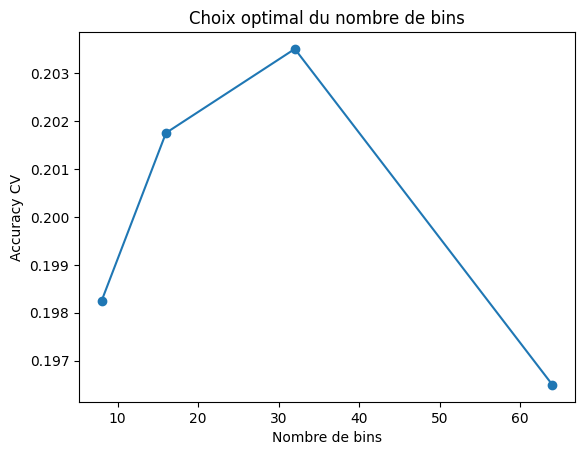

In [ ]:
# choix du meilleur compromis bins  / performance
from sklearn.ensemble       import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot    as plt

candidate_bins = [8, 16, 32, 64]
results = {}

# df_sorted est votre DataFrame final, avec au moins la colonne 'filepath'
for b in candidate_bins:
    # calculer les résumés pour ce nombre de bins
    df_test = compute_color_summaries(df_sorted, bins=b)
    
    # préparer X et y
    feat_cols = [c for c in df_test.columns if any(s in c for s in 
                   ['_mean_bin','_std_bin','_entropy_bin'])]
    X = df_test[feat_cols].values
    y = df_test['species'].values  # ou 'class' si vous l'avez

    # CV 
    rf     = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
    scores = cross_val_score(rf, X, y, cv=3, scoring='accuracy')
    results[b] = scores.mean()

# tracage
plt.plot(list(results.keys()), list(results.values()), marker='o')
plt.xlabel("Nombre de bins")
plt.ylabel("Accuracy CV")
plt.title("Choix optimal du nombre de bins")
plt.show()



In [67]:
print("le bin optimal est 32, c'est celui qui donne le meilleure accuracy")

le bin optimal est 32, c'est celui qui donne le meilleure accuracy


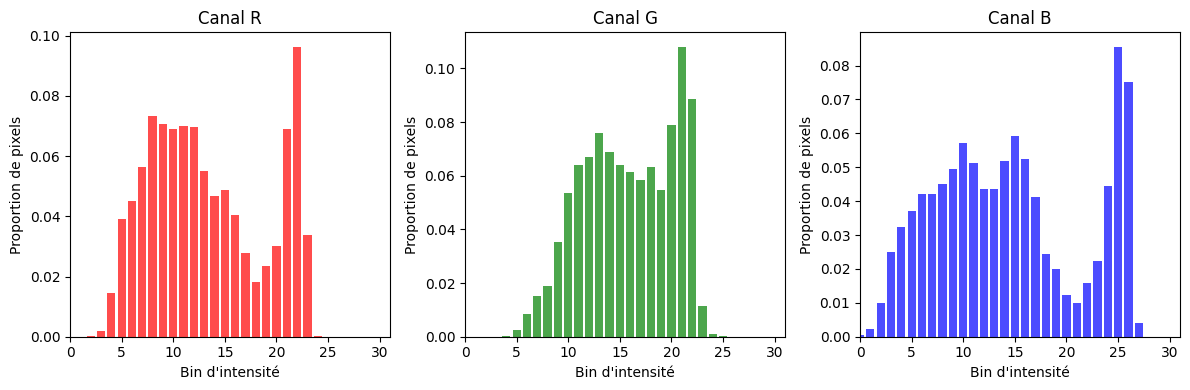

(96,)


In [68]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_and_plot_color_histogram(img_path: str, bins: int = 32):
    """
    1) Charge une image segmentée depuis `img_path`
    2) Calcule l'histogramme normalisé sur `bins` intervalles pour chaque canal R/G/B
    3) Affiche les trois sous‐plots côte à côte avec titres et axes annotés
    4) Retourne le vecteur d’histogramme (3 x bins)
    """
    # --- Chargement et conversion ---
    img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img_bgr is None:
        raise FileNotFoundError(f"Image introuvable : {img_path}")
    # OpenCV charge en BGR, on passe en RGB
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # --- Séparation des canaux et préparation de l'affichage ---
    channels     = cv2.split(img_rgb)        # [R, G, B]
    channel_names = ['R', 'G', 'B']
    colors        = ['red', 'green', 'blue']

    # Figure Matplotlib : 1 ligne × 3 colonnes
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

    # --- Pour chaque canal : calcul + affichage ---
    hist_vector = []  # contiendra les bins normalisés pour R, puis G, puis B
    for ax, ch, name, col in zip(axes, channels, channel_names, colors):
        # 1) calcul de l'histogramme brut
        hist = cv2.calcHist([ch], [0], None, [bins], [0, 256]).flatten()
        # 2) normalisation en proportion
        hist /= (hist.sum() + 1e-6)
        hist_vector.append(hist)  # on stocke pour un usage ultérieur

        # 3) tracé de l'histogramme
        ax.bar(
            range(bins),    # position des bins
            hist,           # hauteur
            color=col,      # couleur cohérente
            alpha=0.7       # transparence
        )
        ax.set_title(f"Canal {name}")
        ax.set_xlabel("Bin d'intensité")
        ax.set_ylabel("Proportion de pixels")
        ax.set_xlim(0, bins-1)

    plt.show()

    # Retourne un vecteur unique de taille 3*bins
    return np.hstack(hist_vector)

# On applique à la première image du DataFrame
first_path = df_sorted.loc[0, 'filepath']
# production d'un vecteur 3*32 = 96
hist3x32 = compute_and_plot_color_histogram(first_path, bins=32)

print(hist3x32.shape)  
# -----------------------------------------------
# ANALYSE DES HISTOGRAMMES
# -----------------------------------------------
#
# 1) Position du pic dominant :
#    peak_bin = np.argmax(hist)      # quel bin a la plus forte proportion
#
# 2) Tendance générale :
#    mean_bin  = np.dot(hist, np.arange(bins))  # moyenne pondérée des bin indices
#
# 3) Dispersion (écart-type) :
#    var_bin   = np.dot(hist, (np.arange(bins) - mean_bin)**2)
#    std_bin   = np.sqrt(var_bin)
#
# 4) Asymétrie (skewness) et complexité (entropy) :
#    skewness = (maintenant on calcule le 3e moment centré normalisé)
#    entropy  = -np.sum(hist * np.log(hist + 1e-6))
#
# 5) Ratios extrêmes :
#    dark_ratio   = hist[0]    # trop de bin 0 = sous-expo ou fond
#    bright_ratio = hist[-1]   # trop de bin max = surexpo ou reflet
#
# ★ Interprétation rapide :
#    - peak_bin bas vs haut     : feuille sombre (verts profonds) vs claire (jaune/jaune-brun)
#    - std_bin faible vs élevé  : surface uniforme vs présence de lésions/ombres
#    - entropy faible vs élevé   : distribution mono-modal vs multi-modal
#    - dark/bright extremes      : possible mauvais masque ou artefact


In [69]:
print("Analyse du canal G (vert) : gros pic vers le bin ~20–22 (valeurs d’intensité entre ≃ 128 et 160)")
print("Bin 0 couvre les intensités [0 – 7], bin 1 couvre [8 – 15], …, bin 20 couvre [160 – 167], bin 22 couvre [176 – 183]")
print(" > la majorité des pixels de votre feuille sont bien verts, ce qui est attendu sur des feuilles saines.")

Analyse du canal G (vert) : gros pic vers le bin ~20–22 (valeurs d’intensité entre ≃ 128 et 160)
Bin 0 couvre les intensités [0 – 7], bin 1 couvre [8 – 15], …, bin 20 couvre [160 – 167], bin 22 couvre [176 – 183]
 > la majorité des pixels de votre feuille sont bien verts, ce qui est attendu sur des feuilles saines.


In [70]:
df_final = compute_color_summaries(df_sorted, bins=32)
print(df.shape)
# repère toutes les colonnes dont le nom commence par "col_hist_bin"
hist_cols = [c for c in df_final.columns if c.startswith("col_hist_bin")]

# suppression pour ne conserver que les résumés mean/std/skew/entropy/dark/bright
df_final.drop(columns=hist_cols, inplace=True)
print(df.shape)
display(df_final.head())

(570, 13)
(570, 13)


,filepath,variant,species,disease,width,height,mode,mean_R,mean_G,mean_B,...,G_skewness_bin,G_entropy_bin,G_dark_ratio,G_bright_ratio,B_mean_bin,B_std_bin,B_skewness_bin,B_entropy_bin,B_dark_ratio,B_bright_ratio
0,../dataset/plantvillage/data/plantvillage_5ima...,color,Apple,_Apple_scab,256,256,RGB,110.662399,130.183029,119.862732,...,-0.204474,-545235.039784,0.000000,0.000000,14.546890,7.187538,0.202119,-522067.137928,0.000366,0.000000
1,../dataset/plantvillage/data/plantvillage_5ima...,color,Apple,_Apple_scab,256,256,RGB,84.160263,97.555771,103.142639,...,-0.529120,-568233.379949,0.000000,0.000000,12.454819,5.994736,0.120735,-533003.741560,0.000092,0.000000
2,../dataset/plantvillage/data/plantvillage_5ima...,color,Apple,_Apple_scab,256,256,RGB,92.535965,125.726334,116.025253,...,1.707267,-563465.051235,0.000000,0.015854,14.065567,4.685083,0.624482,-539329.127339,0.000000,0.000870
3,../dataset/plantvillage/data/plantvillage_5ima...,color,Apple,_Apple_scab,256,256,RGB,129.896759,125.648727,114.409760,...,-0.115656,-515048.964071,0.000656,0.003189,13.858490,8.205591,0.580575,-520499.552928,0.000809,0.012985
4,../dataset/plantvillage/data/plantvillage_5ima...,color,Apple,_Apple_scab,256,256,RGB,86.708450,101.711456,101.433350,...,-0.316323,-556180.261319,0.000046,0.000000,12.243210,5.455789,0.499784,-540650.154144,0.000061,0.000000


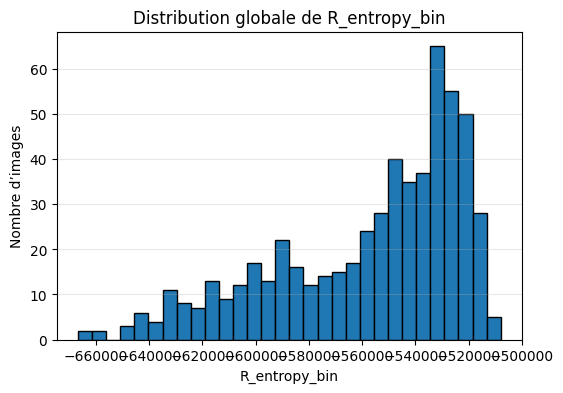

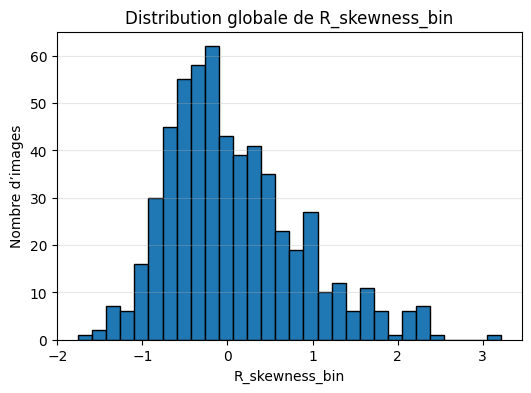

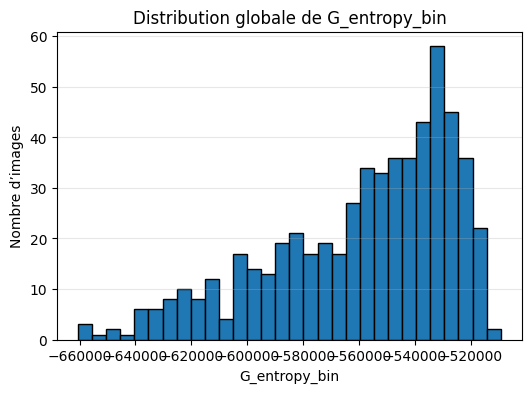

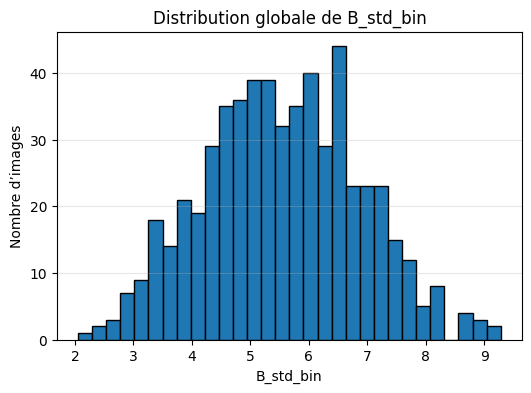

C:\Users\PERCHECMorgan\AppData\Local\Temp\ipykernel_7100\419249275.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


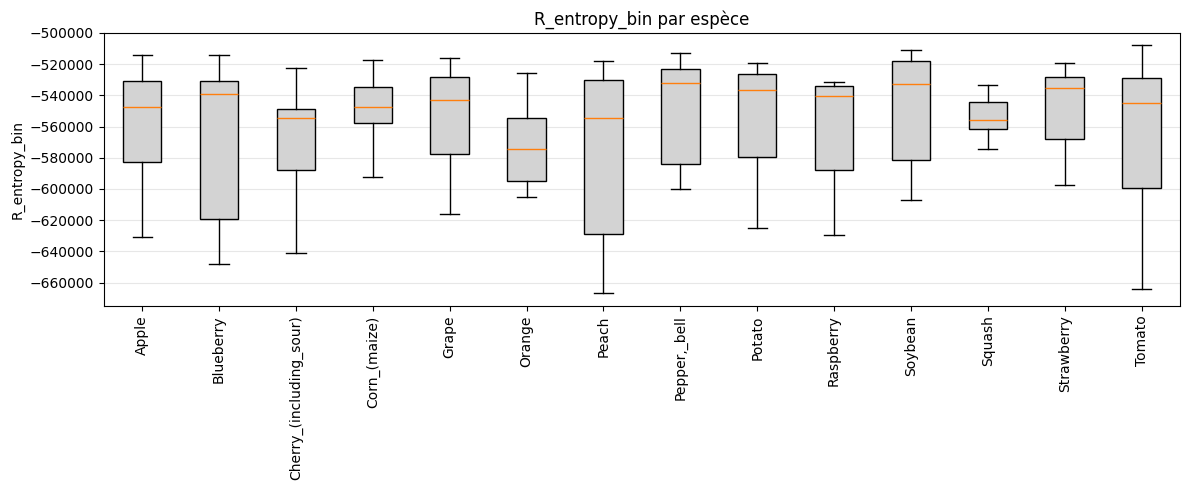

C:\Users\PERCHECMorgan\AppData\Local\Temp\ipykernel_7100\419249275.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


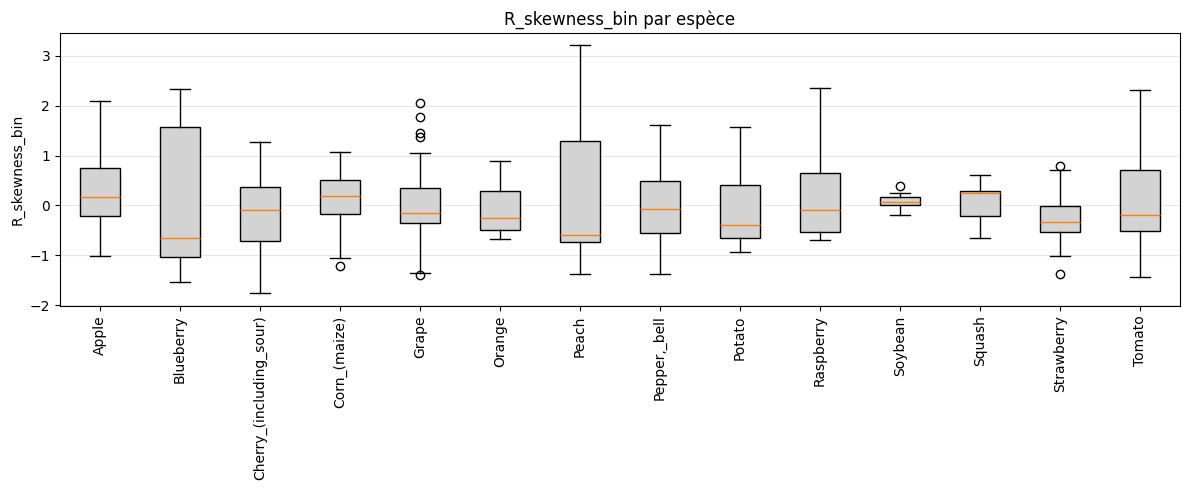

C:\Users\PERCHECMorgan\AppData\Local\Temp\ipykernel_7100\419249275.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


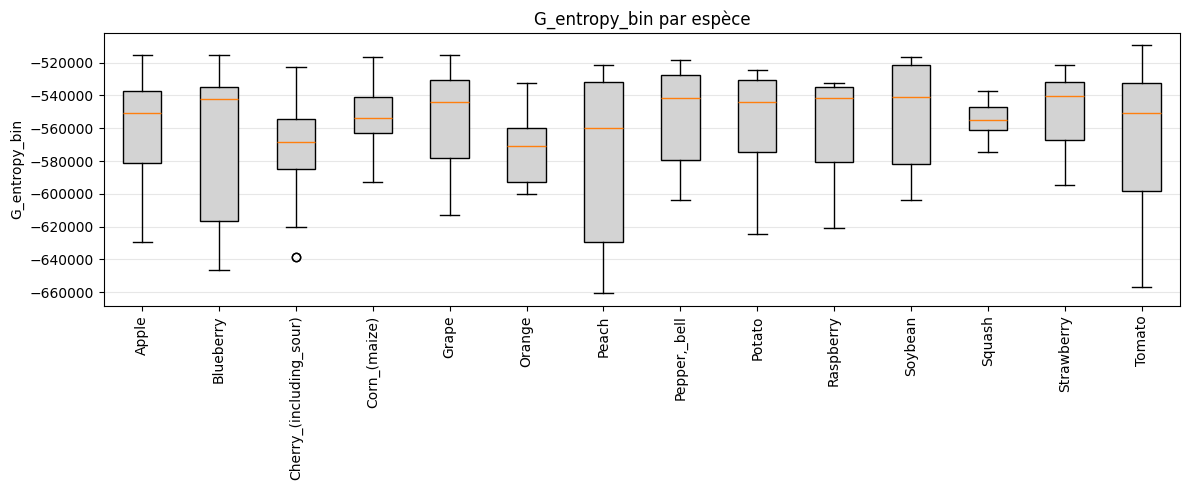

C:\Users\PERCHECMorgan\AppData\Local\Temp\ipykernel_7100\419249275.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


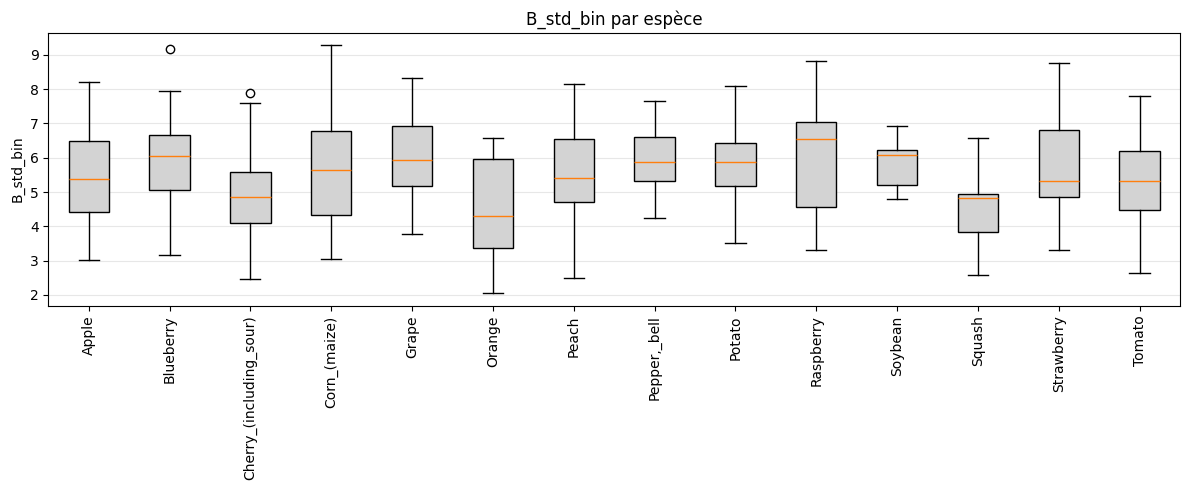

In [ ]:
import matplotlib.pyplot as plt




# Histogrammes globaux pour voir la forme de la distribution
features = ['R_entropy_bin', 'R_skewness_bin', 'G_entropy_bin', 'B_std_bin']

# pour chque feature, tracage histogramme sur l'ensemble des images > voir si feature est unimodale ou multimodale
for feat in features:
    plt.figure(figsize=(6,4))
    # tracé de l’histogramme
    plt.hist(df_final[feat], bins=30, edgecolor='black')
    plt.title(f"Distribution globale de {feat}")
    plt.xlabel(feat)
    plt.ylabel("Nombre d’images")
    plt.grid(axis='y', alpha=0.3)
    plt.show()


# Boxplots par classe = species pour évaluer la séparation
classes = df_final['species'].unique()

for feat in features:
    # rassembler les données par classe
    data_by_cls = [df_final.loc[df_final['species']==cls, feat].values
                   for cls in classes]

    plt.figure(figsize=(12,5))
    plt.boxplot(
        data_by_cls,
        labels=classes,
        showfliers=True,    # affiche les outliers
        patch_artist=True,
        boxprops=dict(facecolor='lightgray', edgecolor='black')
    )
    plt.xticks(rotation=90)
    plt.title(f"{feat} par espèce")
    plt.ylabel(feat)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [57]:
print("Analyse des histo et boxplot A SUIVRE")
print("TO DO ensuite : identifier outlier et comprendre anomalies + tagguer outlier pour les filtrer")

Analyse des histo et boxplot A SUIVRE
TO DO ensuite : identifier outlier et comprendre anomalies + tagguer outlier pour les filtrer


In [ ]:
feature_cols = [] # mettre les moyene + ecart type et aussi entropy et autre sfeatures calculéees en temps 2
# from sklearn.model_selection import train_test_split

# df_train, df_test = train_test_split(
#     df_clean,
#     test_size=0.2,
#     stratify=df_clean['stratify_key'],
#     random_state=42
# )


# X_train = df_train[feature_cols].values
# y_train = df_train['species'].values

# X_test  = df_test[feature_cols].values
# y_test  = df_test['species'].values